In [1]:
# file: py_c2bec2d/gpe_xmds.py

import shlex, subprocess
import numpy as np

import h5py

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt 
plt.style.use(['tableau-colorblind10'])

In [8]:
# file: py_c2bec2d/gpe_xmds.py

def run_shell_command(cmdline, output=True):
    print("run shell command: ", cmdline, "\n")
    args = shlex.split(cmdline)
    # let's use the new run command
    p = subprocess.run(args, stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
    if output:
        print(p.stdout.decode('utf-8'))
        return p.stderr    

In [9]:
run_shell_command('ls', output=False)

run shell command:  ls 



# GP Solution with xmds2

## Generate xmds file with desired number of lattice points, ranges in $x$ and $y$ coordinates, maximum simulation time etc.

In [14]:
# file: py_c2bec2d/gpe_xmds.py

def generate_xmdsfile(xmax=10.0, ymax=10, nlat=128, tmax=1, xmdstol=1.e-8,
                      nsamples1=4, nsamples2=4, args_in_filename="no",
                      xmds_compile="compile_gpe.xmds",
                      xmdstemplate="template_gpe.xmds"):

    # Read in the template file
    with open(xmdstemplate, 'r') as file :
      filedata = file.read()
    
    # Replace the target strings
    filedata = filedata.replace('xmaxVALUE',   str(xmax))
    filedata = filedata.replace('ymaxVALUE',   str(ymax))
    filedata = filedata.replace('nlatVALUE',   str(nlat))
    filedata = filedata.replace('nsamples1VALUE',   str(nsamples1))
    filedata = filedata.replace('nsamples2VALUE',   str(nsamples2))
    filedata = filedata.replace('tmaxVALUE',   str(tmax))
    filedata = filedata.replace('tolVALUE',    str(xmdstol))
    filedata = filedata.replace('argsVALUE',   args_in_filename)

    # Write out the file to be compiledb
    with open(xmds_compile, 'w') as file:
      file.write(filedata)
    
    print("xmds file to compile: "+xmds_compile)

In [132]:
# Simulation parameters
xmax=10
ymax=xmax
nlat=128

In [133]:
generate_xmdsfile(tmax=1, nlat=nlat)

xmds file to compile: compile_gpe.xmds


In [134]:
# file: py_c2bec2d/gpe_xmds.py

def compile_xmds(xmds_compile="compile_gpe.xmds", output=True):
    cmdline  = 'xmds2 '+xmds_compile
    return run_shell_command(cmdline,output=output)

In [135]:
stderr = compile_xmds(output=True)

run shell command:  xmds2 compile_gpe.xmds 

xmds2 version 3.0.0 "Release the Kraken" (r3071)
Copyright 2000-2019 Graham Dennis, Joseph Hope, Mattias Johnsson
                    and the xmds team
Generating source code...
... done
Compiling simulation...
... done. Type './xgpe2d' to run.



## create and save initial wave function 

In [145]:
def save_real_func_as_h5(xa, ya, sa, Vext, variable_name="Vext0", file_name="func.h5"):
    import h5py
    hf = h5py.File(file_name, "w")
    hf.create_dataset("x", data=xa)
    hf.create_dataset("y", data=ya)
    hf.create_dataset("s", data=sa)
    hf.create_dataset(variable_name, data=Vext)
    hf.close()
    print("saved file "+file_name)

def save_complex_func_as_h5(xa, ya, sa, phi0, variable_name="phi0", file_name="cfunc.h5"):
    import h5py
    hf = h5py.File(file_name, "w")
    hf.create_dataset("x", data=xa)
    hf.create_dataset("y", data=ya)
    hf.create_dataset("s", data=sa)
    hf.create_dataset(variable_name+"R", data=phi0.real)
    hf.create_dataset(variable_name+"I", data=phi0.imag)
    hf.close()
    print("saved file "+file_name)

In [146]:
xa = np.linspace(-xmax,xmax,nlat+1)[:-1]
ya = np.linspace(-ymax,ymax,nlat+1)[:-1]
sa = np.array([1, 2])


xx, yy, ss= np.meshgrid(xa,ya,sa,indexing='xy')  ### changed the index by 'xy' from 'ij'

r2 = xx**2 + yy**2 
σ2 = ss

phi0 = np.exp(-r2/(2*σ2))+0*1j
norm2 = np.sum(np.abs(phi0)**2,axis=(0,1))*(xa[1]-xa[0])*(ya[1]-ya[0])
#print(norm2)
phi0[:,:,0] = phi0[:,:,0]/np.sqrt(norm2[0])
phi0[:,:,1] = phi0[:,:,1]/np.sqrt(norm2[1])

saved file 2phi0.h5


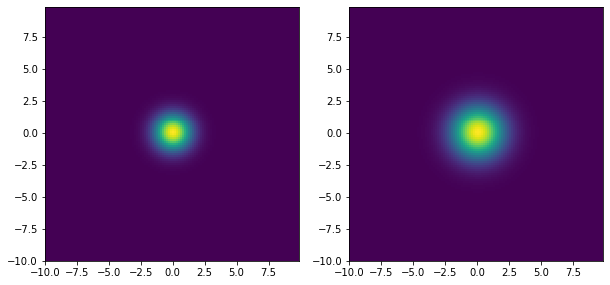

In [147]:
fig, ax = plt.subplots(1,2,figsize=(10,5))

for i in range(2):
    ax[i].pcolor(xa,ya,phi0.real[:,:,i])
    ax[i].set_aspect(1.)
    
save_complex_func_as_h5(xa, ya, sa, phi0, file_name="2phi0.h5")

## create and save external potential

In [148]:
save_real_func_as_h5(xa, ya, sa, phi0.real, file_name="2Vext.h5")

saved file 2Vext.h5


In [149]:
def run_xmds(args_dict={"r0":0}, exefile="xgpe2d", output=True):
    # run simulation
    # ./xgpe2d --r0=0 etc.
    cmdline  = 'nice -19 ./'+exefile
    for arg in args_dict:
        cmdline+=" --"+arg+"="+str(args_dict[arg])
    
    return run_shell_command(cmdline,output=output)

In [150]:
run_xmds()

run shell command:  nice -19 ./xgpe2d --r0=0 

Found enlightenment... (Importing wisdom)
Planning for (x, y) <---> (kx, ky) transform... done.
Planning for (x, y) <---> (kx, ky) transform... done.
Sampled field (for moment group #1) at t = 0.000000e+00
Sampled field (for moment group #2) at t = 0.000000e+00


 Real/Imag. time evolution of a charged two-component BEC: 


Current timestep: 9.242983e-03
Sampled field (for moment group #1) at t = 2.500000e-01
Sampled field (for moment group #2) at t = 2.500000e-01
Current timestep: 9.212047e-03
Sampled field (for moment group #1) at t = 5.000000e-01
Sampled field (for moment group #2) at t = 5.000000e-01
Current timestep: 9.256916e-03
Sampled field (for moment group #1) at t = 7.500000e-01
Sampled field (for moment group #2) at t = 7.500000e-01
Current timestep: 9.290416e-03
Sampled field (for moment group #1) at t = 1.000000e+00
Sampled field (for moment group #2) at t = 1.000000e+00
Current timestep: 1.058628e-03
Segment 3: minimum times

In [151]:
!ls -lrt

total 12940
-rw-r--r-- 1 subasi subasi     537 Jul  5 14:03 README.md
-rw-r--r-- 1 subasi subasi    2888 Jul  7 22:52 exportnb.py
drwxr-xr-x 2 subasi subasi    4096 Jul  7 22:52 __pycache__
-rw-r--r-- 1 subasi subasi    2783 Jul  7 22:55 exports_c2bec2d_xmds.ipynb
-rw-r--r-- 1 subasi subasi    3282 Jul  7 22:56 environment_c2bec2d_xmds.yml
-rw-r--r-- 1 subasi subasi    8468 Jul  7 22:56 spec-file_c2bec2d_xmds.txt
-rw-r--r-- 1 subasi subasi  361807 Jul  7 23:07 gp2d_xmds.ipynb
-rw-r--r-- 1 subasi subasi   11334 Jul 17 12:48 template_gpe.xmds
-rw-r--r-- 1 subasi subasi   11272 Jul 17 12:48 compile_gpe.xmds
-rw-r--r-- 1 subasi subasi  213399 Jul 17 12:48 xgpe2d.cc
-rwxr-xr-x 1 subasi subasi 6490872 Jul 17 12:49 xgpe2d
-rw-r--r-- 1 subasi subasi   26415 Jul 17 12:51 gpe_c2bec2d_xmds.ipynb
-rw-r--r-- 1 subasi subasi  530448 Jul 17 12:53 2phi0.h5
-rw-r--r-- 1 subasi subasi  268304 Jul 17 12:53 2Vext.h5
-rw-r--r-- 1 subasi subasi   12972 Jul 17 12:53 out_gpe.xsil
-rw-r--r-- 1 subasi subasi 52